Inspired in: https://playground.tensorflow.org/

In [10]:
using Pkg
Pkg.activate("..")

  Activating environment at `E:\Projects\OCDNN.jl\Project.toml`


In [26]:
using Revise
using PyPlot, OCDNN, Printf, Random, Serialization

In [13]:
function in_dir(f, path::String)
    current = pwd()
    cd(path)
    f()
    cd(current)
end

in_dir (generic function with 1 method)

In [119]:
Random.seed!(1234)
dataset = build_dataset(N_samples = 200, N_noise = 20);
data, feat = dataset;

In [120]:
N,d = size(data);

In [121]:
idxs = feat .== 1;

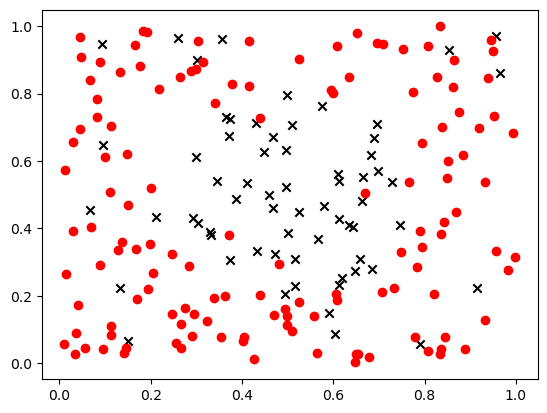

PyObject <matplotlib.collections.PathCollection object at 0x00000000A4859DC0>

In [122]:
scatter(data[:,1][idxs],data[:,2][idxs],marker="x", c = "k")
scatter(data[:,1][.!idxs],data[:,2][.!idxs],marker="o", c = "r")

In [195]:
nlayers = 15
channels = 3 # number of neurons per layer
niter = 10000
τ=0.1;
τ_max=10;
stepsize = 0.1;

In [196]:
A_eu = reshape([0],(1,1));
w_eu = [1];
A_ie = [0 0; 1 0];
w_ie = [0.5 ;0.5];
A_kutta4 = [0 0 0 0;0.5 0 0 0;0 0.5 0 0;0 0 1 0];
w_kutta4 = 1/6*[1;2;2;1];
A_kutta3 = [0 0 0;1/2 0 0;-1 2 0];
w_kutta3 = [1/6;2/3;1/6];

In [197]:
rk4 = OCDNN.ExplicitRungeKutta(A_kutta4,w_kutta4,"RK4");
rk3 = OCDNN.ExplicitRungeKutta(A_kutta3,w_kutta3,"RK3");
rk2 = OCDNN.ExplicitRungeKutta(A_ie,w_ie,"RK2");
euler = OCDNN.ExplicitRungeKutta(A_eu,w_eu,"Euler");
rks = [euler,rk2,rk3,rk4];

In [198]:
names = [rk.name for rk in rks];

In [199]:
eta = x -> exp(x)/(exp(x)+1)

#143 (generic function with 1 method)

In [200]:
problem = OCDNN.Problem(tanh, eta, feat);

In [201]:
function cb(iter, rkmethod, nlayers, α, log, Ctrls)
    period = 2000
    if rem(iter,period) == 0 || iter == 1
        @printf("\nMethod=%s, nlayers=%d, channels=%d\n",rkmethod.name,nlayers,Ctrls.channels)
        @printf("Iteration no: %d\n",iter)
        @printf("Value of alpha: %7.4f\n",α);
        @printf("Residual: %8.4f\n",log.loss[end])
        @printf("Norm Grad: %8.4e\n",log.grad_norm[end]);
        @printf("Accuracy: %8.4f %% \n",log.accuracy[end]*100);
        if iter > 1
            @printf("Time: %8.4f\n",sum(log.time[end-period+1:end]));
        end
    end
end

cb (generic function with 1 method)

In [202]:
all_results = [train_ode_dnn(dataset, nlayers, channels, rk, niter, τ, τ_max, stepsize, problem, cb) for rk in rks];


Method=Euler, nlayers=15, channels=3
Iteration no: 1
Value of alpha:  0.1000
Residual:  21.9037
Norm Grad: 5.8608e+00
Accuracy:  67.5000 % 

Method=Euler, nlayers=15, channels=3
Iteration no: 2000
Value of alpha:  0.0250
Residual:  10.0755
Norm Grad: 1.2119e-01
Accuracy:  89.0000 % 
Time:   4.4768

Method=Euler, nlayers=15, channels=3
Iteration no: 4000
Value of alpha:  0.0063
Residual:   9.5352
Norm Grad: 1.8898e-01
Accuracy:  90.0000 % 
Time:   4.9595

Method=Euler, nlayers=15, channels=3
Iteration no: 6000
Value of alpha:  0.0125
Residual:   9.0723
Norm Grad: 1.6092e-01
Accuracy:  91.0000 % 
Time:   5.2207

Method=Euler, nlayers=15, channels=3
Iteration no: 8000
Value of alpha:  0.0125
Residual:   8.6744
Norm Grad: 1.6357e-01
Accuracy:  91.5000 % 
Time:   5.3836

Method=Euler, nlayers=15, channels=3
Iteration no: 10000
Value of alpha:  0.0031
Residual:   8.4291
Norm Grad: 1.7615e-01
Accuracy:  91.5000 % 
Time:   5.2074

Method=RK2, nlayers=15, channels=3
Iteration no: 1
Value of al

In [203]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(channels)*"_channels"
traineddir = "..\\train\\Classification\\"*final_string*".tmp"
serialize(traineddir, all_results)

In [204]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(channels)*"_channels"
outputdir = "..\\images\\Classification\\"*final_string
if !isdir(outputdir)
    mkdir(outputdir)
end

"..\\images\\Classification\\15_layers_200_points_3_channels"

In [205]:
all_Ctrls,all_logs = first.(all_results),last.(all_results);

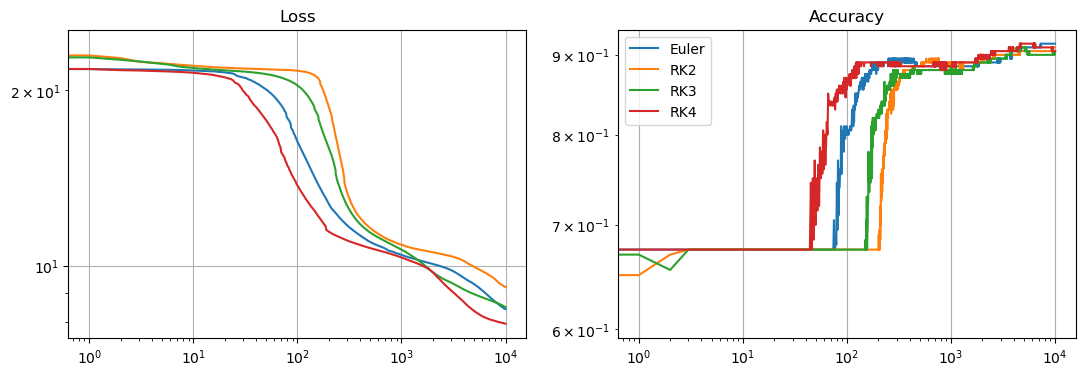

PyObject <matplotlib.legend.Legend object at 0x00000000A5BD9520>

In [206]:
fig, axs = PyPlot.subplots(1,2,figsize=(13,4))
axs[1].set_title("Loss")
for i in 1:4
    axs[1].loglog(all_logs[i].loss, label = names[i])
end
axs[1].grid()
axs[2].set_title("Accuracy")
for i in 1:4
    axs[2].loglog(all_logs[i].accuracy, label = names[i])
end
axs[2].grid()
legend()

In [207]:
in_dir(outputdir) do
    fig.savefig("loss_acc_rks_"*final_string*".pdf")
end

In [208]:
all_times = [sum(all_logs[i].time) for i in 1:4];

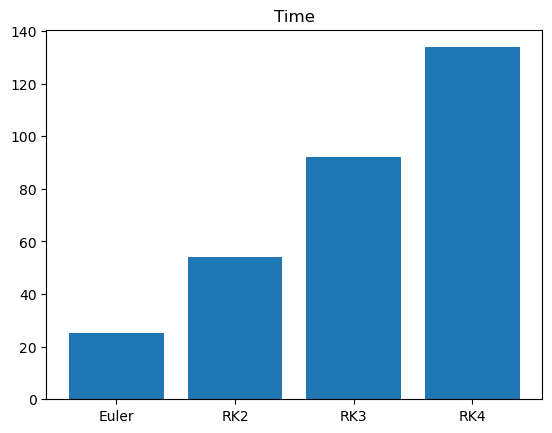

In [209]:
fig, ax = PyPlot.subplots()
ax.set_title("Time")
ax.bar(1:4,height=all_times)
ax.set_xticks(1:4)
ax.set_xticklabels(names);

In [210]:
in_dir(outputdir) do
    fig.savefig("time_rks_"*final_string*".pdf")
end

In [211]:
all_Ctrls_test = deepcopy.(all_Ctrls);

In [212]:
xs = collect(0:0.002:1)
ys = collect(0:0.002:1);

In [213]:
Y0_test = [[x,y] for x in xs, y in ys];

In [214]:
for i in 1:4
    all_Ctrls_test[i].Y0 = hcat(Y0_test...)';
end

In [215]:
classifiers = [[] for i in 1:4]
for i in 1:4
    classifiers[i] = OCDNN.RKforwardstepper(all_Ctrls_test[i],rks[i],problem).Classifier;
end

In [216]:
values = [reshape(round.(classifiers[i]), size(Y0_test))' for i in 1:4];

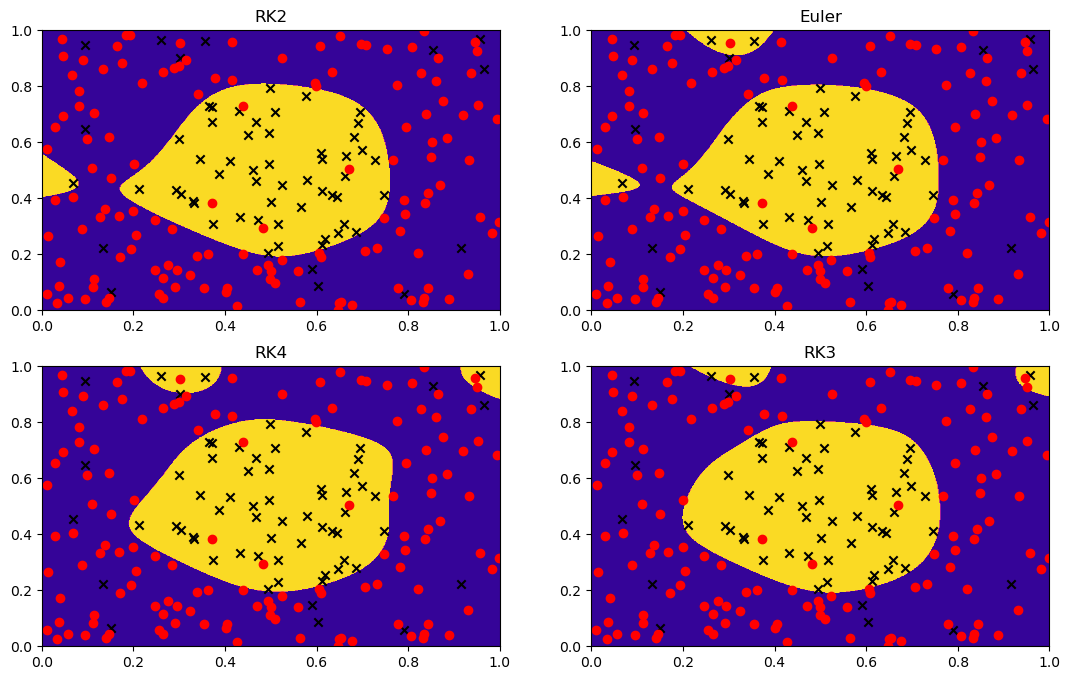

In [217]:
fig, axs = PyPlot.subplots(2,2,figsize=(13,8))
for i in 1:4
    m,n = Int64(floor((i+1)/2)),(i%2)+1
    axs[m,n].set_title(names[i])
    axs[m,n].contourf(xs,ys, values[i], cmap = "plasma")
    axs[m,n].scatter(data[:,1][idxs],data[:,2][idxs],marker="x", c = "k")
    axs[m,n].scatter(data[:,1][.!idxs],data[:,2][.!idxs],marker="o", c = "r")
end

In [218]:
in_dir(outputdir) do
    fig.savefig("contour_plots_rks_"*final_string*".pdf")
end